# MNIST using Trainer
http://docs.chainer.org/en/stable/examples/mnist.html

In [1]:
import numpy as np
import chainer
from chainer.backends import cuda
from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

## 1. Prepare the dataset

In [2]:
from chainer.datasets import mnist

train, test = mnist.get_mnist()

## 2. Prepare the dataset iterations

In [3]:
batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

## 3. Prepare the model

In [5]:
class MLP(Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(None, n_mid_units)
            self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

#gpu_id = 0  # Set to -1 if you use CPU
gpu_id = -1

model = MLP()
if gpu_id >= 0:
    model.to_gpu(gpu_id)

## 4. Prepare the Updater

In [6]:
max_epoch = 10

# Wrap your model by Classifier and include the process of loss calculation within your model.
# Since we do not specify a loss function here, the default 'softmax_cross_entropy' is used.
model = L.Classifier(model)

# selection of your optimizing method
optimizer = optimizers.MomentumSGD()

# Give the optimizer a reference to the model
optimizer.setup(model)

# Get an updater that uses the Iterator and Optimizer
updater = training.updaters.StandardUpdater(train_iter, optimizer, device=gpu_id)

## 5. Setup Trainer

In [7]:
# Setup a Trainer
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='mnist_result')

## 6. Add Extensions to the Trainer object

In [8]:
from chainer.training import extensions

trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

## 7. Start Training

In [9]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.534609    0.849697       0.265158              0.926028                  4.72807       
2           0.234365    0.932536       0.194193              0.940961                  7.61743       
3           0.177398    0.948861       0.166936              0.949763                  12.6022       
4           0.143557    0.958701       0.12929               0.961135                  16.9765       
5           0.1199      0.964652       0.116852              0.964597                  20.7746       
6           0.103325    0.969783       0.106764              0.966673                  26.0883       
7           0.0904647   0.973481       0.0977948             0.970332                  30.4422       
8           0.0805327   0.976362       0.0872738             0.973794                  34.4289       
9           0.0713968   0.978178       0.0893965             0.97142                

loss.png
<img src="mnist_result/loss.png" width="600px">

accuracy.png
<img src="mnist_result/accuracy.png" width="600px">

In [14]:
!dot -Tpng mnist_result/cg.dot -o mnist_result/cg.png

cg.png
<img src="mnist_result/cg.png" width="600px">

## 8. Evaluate a pre-trained model

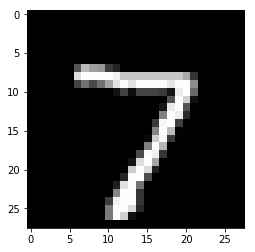

label: 7
predicted_label: 7


In [17]:
import matplotlib.pyplot as plt

model = MLP()
serializers.load_npz('mnist_result/model_epoch-10', model)

# Show the output
x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

y = model(x[None, ...])

print('predicted_label:', y.data.argmax(axis=1)[0])